Authors:

- Kacper Kuźnik 75267
- Mikołaj Nowacki 75231

In [ ]:
# TODO: Uncomment the following lines to install the necessary libraries:

!pip install datasets transformers timm wandb matplotlib albumentations
!pip install torchmetrics
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 9.3 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np

# MacOS Users: Uncomment the following line to enable MPS fallback
#os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

import torch
from PIL import ImageDraw, Image

checkpoint_detr = "PekingU/rtdetr_r50vd"
checkpoint_detrv2 = "PekingU/rtdetr_v2_r50vd"

# This guide will use RT-DETR v2
checkpoint = checkpoint_detrv2

# Select input image size
image_size = 480

# %load_ext autoreload
# %autoreload 2

## Loading the dataset


In [ ]:
# Mapping between class IDs and labels

label2id = {'Plastic bag & wrapper': 0,
  'Cigarette': 1,
  'Bottle': 2,
  'Bottle cap': 3,
  'Can': 4,
  'Carton': 5}

id2label = {v: k for k, v in label2id.items()}
label2id, id2label
categories = list(id2label.values())

## Preprocess the data

In [ ]:
from transformers import AutoImageProcessor

# Instantiate the image processor
image_processor = AutoImageProcessor.from_pretrained(
    checkpoint,         # The checkpoint of the model we want to finetune
    do_resize=True,     # Resize the images to the expected size
    size={"width": image_size, "height": image_size},
    use_fast=True,      # Use the fast version of the processor
)

#### Data Augmentation

To make sure the model does not overfit on the training data, we can apply image augmentation. Example augmentations include horizontal flipping, brightness adjustment, perspective change, etc.


In [ ]:
import albumentations as A

train_augmentation_and_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.1),
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"], clip=True,
                            min_area=25,        # Discard boxes smaller than 5x5 pixels
                            min_visibility=0.1, # Discard boxes if <10% remains after cropping
                            filter_invalid_bboxes=True,
                            min_width=1,
                            min_height=1
                            ),
)

validation_transform = A.Compose(
    [A.NoOp()],
    bbox_params=A.BboxParams(format="coco", label_fields=["category"],
                             clip=True,
                             min_visibility=0.1, # Discard boxes if <10% remains after cropping
                            filter_invalid_bboxes=True,
                            min_width=1,
                            min_height=1
                            ),
)

#### Image Pre-processing to match RT-DETR format


In [ ]:
from taco_dataset import TACODETRDetectionDataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_root = "/content/drive/MyDrive/CV-project/Taco_subset"

In [ ]:
train_dataset = TACODETRDetectionDataset(
    img_folder=dataset_root,
    ann_file=f"{dataset_root}/annotations_train.json",
    processor=image_processor,
    transform=train_augmentation_and_transform
)

validation_dataset = TACODETRDetectionDataset(
    img_folder=dataset_root,
    ann_file=f"{dataset_root}/annotations_val.json",
    processor=image_processor,
    transform=validation_transform
)

test_dataset = TACODETRDetectionDataset(
    img_folder=dataset_root,
    ann_file=f"{dataset_root}/annotations_test.json",
    processor=image_processor,
    transform=validation_transform
)


# Inpsect a sample from the training dataset
train_dataset[0]

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


{'pixel_values': tensor([[[0.1176, 0.1373, 0.1333,  ..., 0.3333, 0.3059, 0.2784],
          [0.1216, 0.1255, 0.1216,  ..., 0.3098, 0.3059, 0.3294],
          [0.1098, 0.1333, 0.1176,  ..., 0.3176, 0.3216, 0.3255],
          ...,
          [0.4510, 0.4627, 0.4471,  ..., 0.2667, 0.2745, 0.2549],
          [0.4039, 0.4078, 0.4196,  ..., 0.2706, 0.2706, 0.2824],
          [0.4039, 0.4196, 0.4510,  ..., 0.3255, 0.2824, 0.3137]],
 
         [[0.0902, 0.1137, 0.1059,  ..., 0.2039, 0.1725, 0.1451],
          [0.1020, 0.1059, 0.1020,  ..., 0.1843, 0.1765, 0.1961],
          [0.0902, 0.1137, 0.1020,  ..., 0.1961, 0.2000, 0.2039],
          ...,
          [0.3922, 0.4039, 0.3882,  ..., 0.2275, 0.2392, 0.2196],
          [0.3490, 0.3529, 0.3608,  ..., 0.2275, 0.2275, 0.2392],
          [0.3569, 0.3725, 0.4000,  ..., 0.2824, 0.2392, 0.2627]],
 
         [[0.1216, 0.1412, 0.1373,  ..., 0.1961, 0.1647, 0.1412],
          [0.1255, 0.1294, 0.1255,  ..., 0.1725, 0.1686, 0.1922],
          [0.1137, 0.137

Image tensor shape: torch.Size([3, 480, 480])
Boxes shape: (4, 4)
Categories shape: (4,)


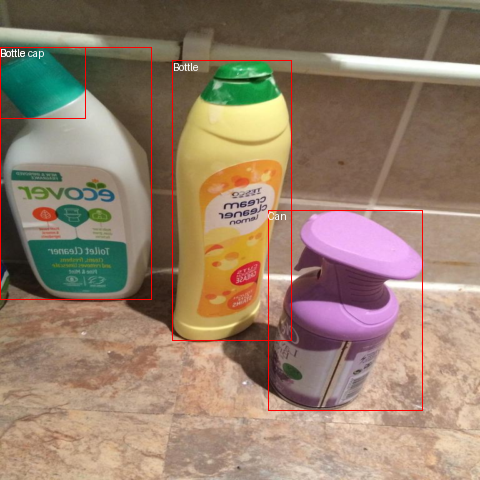

Image tensor shape: torch.Size([3, 480, 480])
Boxes shape: (1, 4)
Categories shape: (1,)


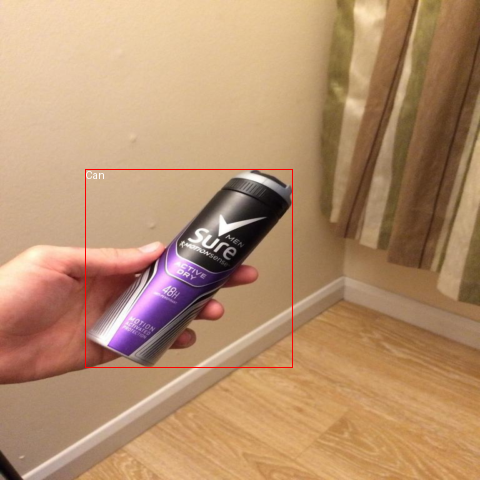

Image tensor shape: torch.Size([3, 480, 480])
Boxes shape: (1, 4)
Categories shape: (1,)


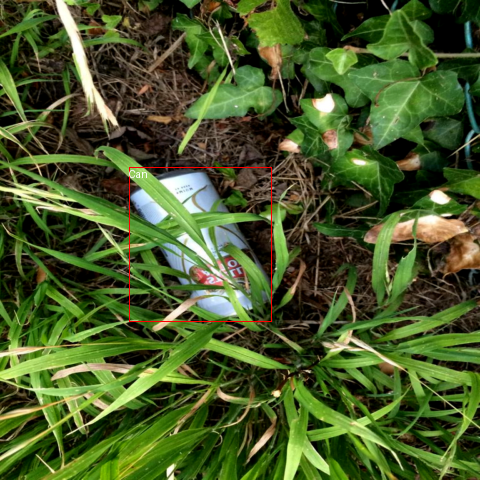

In [ ]:
for i in [15, 16, 17]:
    sample = train_dataset[i]

    # De-normalize image
    image = sample["pixel_values"]
    print("Image tensor shape:", image.shape)
    image = image.numpy().transpose(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min()) * 255.
    image = Image.fromarray(image.astype(np.uint8))

    # Convert boxes from [center_x, center_y, width, height] to [x, y, width, height] for visualization
    boxes = sample["labels"]["boxes"].numpy()
    print("Boxes shape:", boxes.shape)
    boxes[:, :2] = boxes[:, :2] - boxes[:, 2:] / 2
    w, h = image.size
    boxes = boxes * np.array([w, h, w, h])[None]

    categories = sample["labels"]["class_labels"].numpy()
    print("Categories shape:", categories.shape)

    # Draw boxes and labels on image
    draw = ImageDraw.Draw(image)
    for box, category in zip(boxes, categories):
        x, y, w, h = box
        draw.rectangle([x, y, x + w, y + h], outline="red", width=1)
        draw.text((x, y), id2label[category], fill="white")

    display(image)

### The Data Collator Function: From single samples to batches



In [ ]:
from taco_dataset import taco_detr_collate_fn

## Preparing function to compute mAP

In [ ]:
import numpy as np
import torch
from dataclasses import dataclass
from transformers.image_transforms import center_to_corners_format
from torchmetrics.detection.mean_ap import MeanAveragePrecision


@dataclass
class ModelOutput:
    logits: torch.Tensor
    pred_boxes: torch.Tensor


class MAPEvaluator:

    def __init__(self, image_processor, threshold=0.00, id2label=None):
        self.image_processor = image_processor
        self.threshold = threshold
        self.id2label = id2label

    def collect_image_sizes(self, targets):
        """Collect image sizes across the dataset as list of tensors with shape [batch_size, 2]."""
        image_sizes = []
        for batch in targets:
            batch_image_sizes = torch.tensor(np.array([x["size"] for x in batch]))
            image_sizes.append(batch_image_sizes)
        return image_sizes

    def collect_targets(self, targets, image_sizes):
        post_processed_targets = []
        for target_batch, image_size_batch in zip(targets, image_sizes):
            for target, size in zip(target_batch, image_size_batch):

                # here we have "yolo" format (x_center, y_center, width, height) in relative coordinates 0..1
                # and we need to convert it to "pascal" format (x_min, y_min, x_max, y_max) in absolute coordinates
                height, width = size
                boxes = torch.tensor(target["boxes"])
                boxes = center_to_corners_format(boxes)
                boxes = boxes * torch.tensor([[width, height, width, height]])

                labels = torch.tensor(target["class_labels"])
                post_processed_targets.append({"boxes": boxes, "labels": labels})
        return post_processed_targets

    def collect_predictions(self, predictions, image_sizes):
        post_processed_predictions = []
        for batch, target_sizes in zip(predictions, image_sizes):
            batch_logits, batch_boxes = batch[1], batch[2]
            output = ModelOutput(logits=torch.tensor(batch_logits), pred_boxes=torch.tensor(batch_boxes))
            post_processed_output = self.image_processor.post_process_object_detection(
                output, threshold=self.threshold, target_sizes=target_sizes
            )
            post_processed_predictions.extend(post_processed_output)
        return post_processed_predictions

    @torch.no_grad()
    def __call__(self, evaluation_results):

        predictions, targets = evaluation_results.predictions, evaluation_results.label_ids

        image_sizes = self.collect_image_sizes(targets)
        post_processed_targets = self.collect_targets(targets, image_sizes)
        post_processed_predictions = self.collect_predictions(predictions, image_sizes)

        evaluator = MeanAveragePrecision(box_format="xyxy", class_metrics=True)
        evaluator.warn_on_many_detections = False
        evaluator.update(post_processed_predictions, post_processed_targets)

        metrics = evaluator.compute()

        classes = metrics.pop("classes")
        map_per_class = metrics.pop("map_per_class")
        mar_100_per_class = metrics.pop("mar_100_per_class")
        for class_id, class_map, class_mar in zip(classes, map_per_class, mar_100_per_class):
            class_name = id2label[class_id.item()] if id2label is not None else class_id.item()
            metrics[f"map_{class_name}"] = class_map
            metrics[f"mar_100_{class_name}"] = class_mar

        metrics = {k: round(v.item(), 4) for k, v in metrics.items()}

        return metrics

eval_compute_metrics_fn = MAPEvaluator(image_processor=image_processor,
                                       threshold=0.01, id2label=id2label)

## Training the detection model

In [ ]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/172M [00:00<?, ?B/s]

Some weights of RTDetrV2ForObjectDetection were not initialized from the model checkpoint at PekingU/rtdetr_v2_r50vd and are newly initialized because the shapes did not match:
- model.decoder.class_embed.0.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([6]) in the model instantiated
- model.decoder.class_embed.0.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- model.decoder.class_embed.1.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([6]) in the model instantiated
- model.decoder.class_embed.1.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- model.decoder.class_embed.2.bias: found shape torch.Size([80]) in the checkpoint and torch.Size([6]) in the model instantiated
- model.decoder.class_embed.2.weight: found shape torch.Size([80, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- model.decod

#### Training Hyperparameters


In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="rtdetr-v2-r50-taco-finetune",
    num_train_epochs=10,                # Number of training epochs
    max_grad_norm=0.1,                  # Gradient clipping norm
    learning_rate=5e-5,                 # Learning rate
    warmup_steps=300,                   # Number of warmup steps for learning rate scheduler
    per_device_train_batch_size=8,      # Batch size per device during training
    dataloader_num_workers=2,           # Number of workers for data loading
    metric_for_best_model="eval_map",   # Metric to use to compare models
    greater_is_better=True,             # Whether a higher metric score is better
    load_best_model_at_end=True,        # Load the best model when finished training
    eval_strategy="epoch",              # Evaluation strategy to use
    save_strategy="epoch",              # Save checkpoint strategy to use
    save_total_limit=2,                 # Maximum number of model checkpoints to save
    bf16=True,                          # Use bf16 precision
    remove_unused_columns=False,        # Whether to remove unused columns in the dataset
    eval_do_concat_batches=False,       # Whether to concatenate batches during evaluation
    report_to="wandb",                  # Reporting tool to use
)

#### Running Training


In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    processing_class=image_processor,
    data_collator=taco_detr_collate_fn,
    compute_metrics=eval_compute_metrics_fn,
)

trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss,Map,Map 50,Map 75,Map Small,Map Medium,Map Large,Mar 1,Mar 10,Mar 100,Mar Small,Mar Medium,Mar Large,Map Plastic bag & wrapper,Mar 100 Plastic bag & wrapper,Map Cigarette,Mar 100 Cigarette,Map Bottle,Mar 100 Bottle,Map Bottle cap,Mar 100 Bottle cap,Map Can,Mar 100 Can,Map Carton,Mar 100 Carton
1,No log,52.494820,0.015100,0.021800,0.015100,0.007900,0.029000,0.032100,0.082200,0.173300,0.249000,0.072700,0.293100,0.533000,0.024300,0.284000,0.000000,0.000000,0.043800,0.394300,0.000000,0.040500,0.011600,0.389400,0.010700,0.386100
2,No log,20.611588,0.135400,0.176500,0.138000,0.052300,0.181600,0.221000,0.265600,0.442500,0.527100,0.339000,0.612000,0.857900,0.265500,0.518400,0.006500,0.158100,0.279000,0.651400,0.021800,0.494600,0.177800,0.714900,0.061700,0.625000
3,No log,17.406357,0.239100,0.308100,0.259800,0.116300,0.260000,0.640800,0.321300,0.521800,0.563000,0.407900,0.652700,0.874900,0.262400,0.563200,0.008300,0.138700,0.322000,0.715700,0.157700,0.470300,0.408400,0.751100,0.275400,0.738900
4,No log,15.355035,0.209000,0.283100,0.228700,0.090500,0.253000,0.404400,0.294500,0.506400,0.580200,0.437300,0.655200,0.857200,0.233900,0.592000,0.004700,0.196800,0.330900,0.710000,0.241200,0.548600,0.272700,0.734000,0.170400,0.700000
5,58.843200,14.561399,0.244300,0.334800,0.256900,0.118200,0.289900,0.486700,0.323000,0.514100,0.590200,0.449700,0.639500,0.858800,0.275000,0.570400,0.015500,0.275800,0.421100,0.721400,0.239800,0.562200,0.256200,0.736200,0.257900,0.675000
6,58.843200,13.941071,0.227800,0.303700,0.246000,0.112800,0.294700,0.357000,0.317800,0.495400,0.594000,0.476800,0.626800,0.838000,0.226900,0.543200,0.011400,0.285500,0.477100,0.744300,0.134100,0.575700,0.229100,0.731900,0.288000,0.683300
7,58.843200,13.797214,0.273900,0.370400,0.290800,0.123900,0.319800,0.418500,0.327700,0.524200,0.603200,0.491400,0.645600,0.848400,0.307600,0.599200,0.024500,0.266100,0.498800,0.747100,0.204800,0.559500,0.325600,0.755300,0.282300,0.691700
8,58.843200,13.890966,0.239400,0.315600,0.263800,0.113200,0.306100,0.374700,0.308300,0.498300,0.598100,0.476100,0.639800,0.853500,0.308200,0.571200,0.017100,0.277400,0.458200,0.751400,0.176600,0.594600,0.277200,0.674500,0.199400,0.719400
9,58.843200,13.595944,0.254300,0.338600,0.272000,0.108400,0.318500,0.508400,0.313200,0.513100,0.607800,0.495700,0.633100,0.869100,0.337600,0.588000,0.019500,0.306500,0.481700,0.748600,0.146100,0.567600,0.300600,0.717000,0.240700,0.719400
10,17.812200,13.489388,0.245400,0.325100,0.262200,0.092900,0.312800,0.470700,0.304500,0.505800,0.589300,0.480600,0.614400,0.854100,0.320500,0.576800,0.022900,0.267700,0.497700,0.747100,0.114800,0.581100,0.278400,0.712800,0.237900,0.650000


There were missing keys in the checkpoint model loaded: ['class_embed.0.weight', 'class_embed.0.bias', 'class_embed.1.weight', 'class_embed.1.bias', 'class_embed.2.weight', 'class_embed.2.bias', 'class_embed.3.weight', 'class_embed.3.bias', 'class_embed.4.weight', 'class_embed.4.bias', 'class_embed.5.weight', 'class_embed.5.bias', 'bbox_embed.0.layers.0.weight', 'bbox_embed.0.layers.0.bias', 'bbox_embed.0.layers.1.weight', 'bbox_embed.0.layers.1.bias', 'bbox_embed.0.layers.2.weight', 'bbox_embed.0.layers.2.bias', 'bbox_embed.1.layers.0.weight', 'bbox_embed.1.layers.0.bias', 'bbox_embed.1.layers.1.weight', 'bbox_embed.1.layers.1.bias', 'bbox_embed.1.layers.2.weight', 'bbox_embed.1.layers.2.bias', 'bbox_embed.2.layers.0.weight', 'bbox_embed.2.layers.0.bias', 'bbox_embed.2.layers.1.weight', 'bbox_embed.2.layers.1.bias', 'bbox_embed.2.layers.2.weight', 'bbox_embed.2.layers.2.bias', 'bbox_embed.3.layers.0.weight', 'bbox_embed.3.layers.0.bias', 'bbox_embed.3.layers.1.weight', 'bbox_embed.3.l

TrainOutput(global_step=1000, training_loss=38.3276865234375, metrics={'train_runtime': 2159.1324, 'train_samples_per_second': 3.701, 'train_steps_per_second': 0.463, 'total_flos': 1.41615560176128e+18, 'train_loss': 38.3276865234375, 'epoch': 10.0})

# Evaluation on test dataset


In [ ]:
evaluation_results = trainer.predict(test_dataset)
metrics = eval_compute_metrics_fn(evaluation_results)
print(metrics)


{'map': 0.2467, 'map_50': 0.33, 'map_75': 0.2531, 'map_small': 0.135, 'map_medium': 0.2695, 'map_large': 0.4695, 'mar_1': 0.313, 'mar_10': 0.5138, 'mar_100': 0.5618, 'mar_small': 0.4649, 'mar_medium': 0.6037, 'mar_large': 0.8056, 'map_Plastic bag & wrapper': 0.3179, 'mar_100_Plastic bag & wrapper': 0.6044, 'map_Cigarette': 0.0538, 'mar_100_Cigarette': 0.3066, 'map_Bottle': 0.3899, 'mar_100_Bottle': 0.6549, 'map_Bottle cap': 0.1108, 'mar_100_Bottle cap': 0.4839, 'map_Can': 0.3096, 'mar_100_Can': 0.6694, 'map_Carton': 0.2982, 'mar_100_Carton': 0.6516}


## Inference over Test Images


In [ ]:
import torch
import requests
from PIL import Image, ImageDraw

In [ ]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection

# Update this path to point to your best model checkpoint
best_model_checkpoint = "/content/drive/MyDrive/CV-project/rtdetr-v2-r50-taco-finetune/checkpoint-1000"

image_processor = AutoImageProcessor.from_pretrained(
    best_model_checkpoint,
    do_resize=True,
    size={"width": image_size, "height": image_size},
    use_fast=True,
)

model = AutoModelForObjectDetection.from_pretrained(
    best_model_checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

# failure analysis

In [ ]:
import torch
import requests
from PIL import Image, ImageDraw


def predict_image(image_index):
  # The model always expects a batch, so we need to collate our single sample into a batch
  inputs = taco_detr_collate_fn([train_dataset[image_index]])

  with torch.no_grad():
      outputs = model(**inputs)

  target_sizes = torch.tensor([(image_size, image_size)])

  result = image_processor.post_process_object_detection(outputs,
                                                        threshold=0.1, # Confidence threshold
                                                        target_sizes=target_sizes)[0]

  for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
      box = [round(i, 2) for i in box.tolist()]
      print(
          f"Detected {model.config.id2label[label.item()]} with confidence "
          f"{round(score.item(), 3)} at location {box}"
      )
    # To visualize it, we need to de-normalize the image

  image = inputs["pixel_values"][0]
  image_with_boxes = image.numpy().transpose(1, 2, 0)
  image_with_boxes = (image_with_boxes - image_with_boxes.min()) / (image_with_boxes.max() - image_with_boxes.min()) * 255.
  image_with_boxes = Image.fromarray(image_with_boxes.astype(np.uint8))

  draw = ImageDraw.Draw(image_with_boxes)
  print(result)
  for score, label, box in zip(result["scores"], result["labels"], result["boxes"]):
      box = [round(i, 2) for i in box.tolist()]
      x, y, x2, y2 = tuple(box)
      draw.rectangle((x, y, x2, y2), outline="red", width=1)
      text_label = model.config.id2label[label.item()]
      draw.text((x, y), f"{text_label} [ {score.item():.2f} ]", fill="blue")

  return image_with_boxes

Visualizing the detection results:

In [ ]:
for i in range(100):
  display(predict_image(i))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!zip -r rtdetr-v2-r50-taco-finetune.zip rtdetr-v2-r50-taco-finetune/


  adding: rtdetr-v2-r50-taco-finetune/ (stored 0%)
  adding: rtdetr-v2-r50-taco-finetune/checkpoint-700/ (stored 0%)
  adding: rtdetr-v2-r50-taco-finetune/checkpoint-700/rng_state.pth (deflated 26%)
  adding: rtdetr-v2-r50-taco-finetune/checkpoint-700/preprocessor_config.json (deflated 53%)
  adding: rtdetr-v2-r50-taco-finetune/checkpoint-700/model.safetensors (deflated 7%)
  adding: rtdetr-v2-r50-taco-finetune/checkpoint-700/trainer_state.json (deflated 79%)
  adding: rtdetr-v2-r50-taco-finetune/checkpoint-700/optimizer.pt (deflated 8%)
  adding: rtdetr-v2-r50-taco-finetune/checkpoint-700/config.json (deflated 64%)
  adding: rtdetr-v2-r50-taco-finetune/checkpoint-700/scheduler.pt (deflated 61%)
  adding: rtdetr-v2-r50-taco-finetune/checkpoint-700/training_args.bin (deflated 53%)
  adding: rtdetr-v2-r50-taco-finetune/checkpoint-1000/ (stored 0%)
  adding: rtdetr-v2-r50-taco-finetune/checkpoint-1000/rng_state.pth (deflated 26%)
  adding: rtdetr-v2-r50-taco-finetune/checkpoint-1000/prepr

# Errors

Overall performance was very good, however there were some errors

# 1 False positive
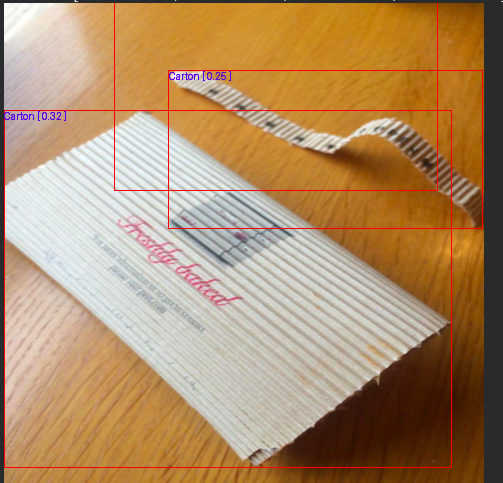


2. False positive
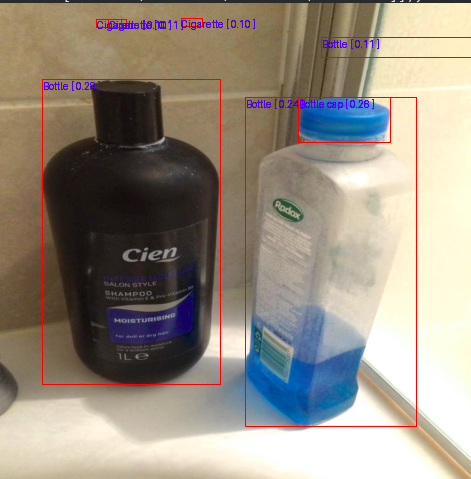

3. False positive
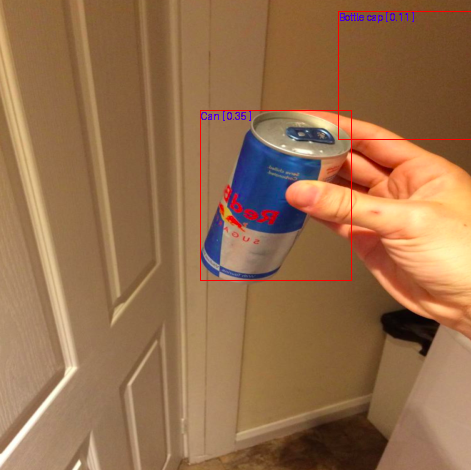

4. Missed object
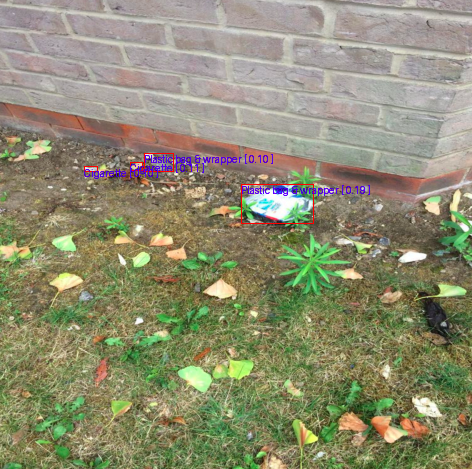